# Carvana Image Masking Challenge
- https://www.kaggle.com/competitions/carvana-image-masking-challenge
- ref. https://www.kaggle.com/code/nandwalritik/u-net-pytorch
- ref. https://www.kaggle.com/code/yousefradwanlmao/carvana-pipeline

In [46]:
# 設定
RUN_TRAINING = False 
RUN_TEST=True
#SAVE_MODEL_DIR_NAME="models_horizon_verticalflip"
SAVE_MODEL_DIR_NAME="models_horizon_flip"


In [47]:
#%matplotlib inline

In [48]:
# !kaggle competitions download -c carvana-image-masking-challenge

In [49]:
!pwd

/torch/work/kenshu/kaggle-training/carvana


In [50]:
!nvidia-smi

Mon Mar  6 06:46:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:0E:00.0 Off |                    0 |
| N/A   43C    P0    52W / 300W |  25891MiB / 32508MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:0F:00.0 Off |                    0 |
| N/A   

In [51]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms
from tqdm import tqdm
import cv2
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import os
import torch.nn.functional as F

## 定数群

In [52]:
# config
LEARNING_RATE = 1e-4
SPLIT=0.2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_BATCH_SIZE = 2
EPOCHS = 12
NUM_WORKERS = 2
IMAGE_HEIGHT = 572
IMAGE_WIDTH = 572
# PIN_MEMORY = True
# BASE_DIR = os.path.abspath(os.path.curdir)
BASE_DIR = '.'
SRC_PATH = '../input/carvana-image-masking-challenge/'
DATAPATH = os.path.join(BASE_DIR, 'data')
# TRAIN_IMG_DIR = os.path.join(DATAPATH, 'train')
TRAIN_IMG_DIR = os.path.join(DATAPATH, 'train')
# TRAIN_MASK_DIR = os.path.join(DATAPATH, 'train_masks')
TRAIN_MASK_DIR = os.path.join(DATAPATH, 'train_masks')

# VAL_IMG_DIR = 
# VAL_MASK_DIR = 

TEST_IMG_DIR = os.path.join(DATAPATH, 'test')
TEST_BATCH_SIZE = 16

SAVE_PATH = os.path.join(BASE_DIR, SAVE_MODEL_DIR_NAME)
MODEL_NAME = "model_9epoch.pt"
MODEL_PATH = os.path.join(SAVE_PATH, MODEL_NAME)
os.makedirs(SAVE_PATH,exist_ok=True)
# MODEL_PATH = os.path.join("/kaggle/input/datasets-for-carvana/", MODEL_NAME)

# データセットの準備

In [53]:
import zipfile
if RUN_TRAINING:
    dirs = ['train.zip','train_masks.zip', 'test.zip', 'metadata.csv.zip', 'sample_submission.csv.zip']
else:
    # dirs = ['test.zip']
    dirs = ['train.zip','train_masks.zip', 'test.zip', 'metadata.csv.zip', 'sample_submission.csv.zip',"train_masks.csv.zip"]

for x in dirs:
    bn = os.path.splitext(os.path.basename(x))[0]
    d = os.path.join(DATAPATH, bn)
    
    if os.path.exists(d):
        print('skip extract', {bn})
        continue
        
    with zipfile.ZipFile(os.path.join(SRC_PATH, x),'r') as z:
        z.extractall(DATAPATH)

skip extract {'train'}
skip extract {'train_masks'}
skip extract {'test'}
skip extract {'metadata.csv'}
skip extract {'sample_submission.csv'}
skip extract {'train_masks.csv'}


## Datasetクラスの作成

In [54]:
class CarvanaDataset(Dataset):
    def __init__(self,images,image_dir,mask_dir=None,transform=None, train=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.isTrain = train
        self.images = images
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,index):
        img_path = os.path.join(self.image_dir,self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))

        if self.isTrain:
            mask_path = os.path.join(self.mask_dir,self.images[index].replace(".jpg","_mask.gif"))
            mask = np.array(Image.open(mask_path).convert("L"),dtype=np.float32)
            mask[mask == 255.0] = 1.0
        
        if self.transform and self.isTrain:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed['image'], transformed['mask']
        elif self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        else:
            pass
            
        if self.isTrain:
            return {"name":os.path.basename(img_path), "image":image, "mask":mask}
        else:
            return {'name': os.path.basename(img_path), 'image': image}

(1280, 1918, 3)
(1280, 1918)


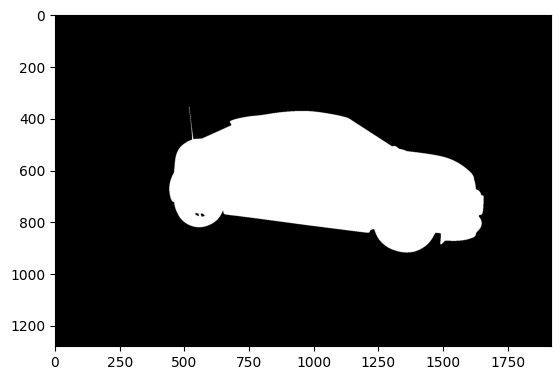

In [55]:
train_images = os.listdir(TRAIN_IMG_DIR)
train_masks = os.listdir(TRAIN_MASK_DIR)

img = np.array(Image.open(TRAIN_IMG_DIR+"/"+train_images[0]).convert("RGB"))
plt.imshow(img,cmap="gray")
print(img.shape)

msk = np.array(Image.open(TRAIN_MASK_DIR+"/"+train_images[0].replace(".jpg","_mask.gif")).convert("L"))
plt.imshow(msk,cmap="gray")
print(msk.shape)

original_shape = msk.shape

## モデルの定義

In [56]:
from typing import List

import torch
import torch.nn as nn


def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )
    return conv.to(DEVICE)


# def crop_img(tensor, target_tensor):
#     target_size = target_tensor.size()[2]
#     tensor_size = tensor.size()[2]
#     delta = tensor_size-target_size
#     delta = delta//2
#     # all batch, all channels, heightModified,widthModified

#     return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]

def addPadding(srcShapeTensor, tensor_whose_shape_isTobechanged):

    if(srcShapeTensor.shape != tensor_whose_shape_isTobechanged.shape):
        target = torch.zeros(srcShapeTensor.shape)
        target[:, :, :tensor_whose_shape_isTobechanged.shape[2],
               :tensor_whose_shape_isTobechanged.shape[3]] = tensor_whose_shape_isTobechanged
        return target.to(DEVICE)
    return tensor_whose_shape_isTobechanged.to(DEVICE)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        )
        self.up_conv_1 = double_conv(1024, 512)

        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        )
        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2
        )
        self.up_conv_3 = double_conv(256, 128)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        )
        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=1,
            kernel_size=1
        )

    def forward(self, image):
        # expected size
        # encoder (Normal convolutions decrease the size)
        x1 = self.down_conv_1(image)
        # print("x1 "+str(x1.shape))
        x2 = self.max_pool_2x2(x1)
        # print("x2 "+str(x2.shape))
        x3 = self.down_conv_2(x2)
        # print("x3 "+str(x3.shape))
        x4 = self.max_pool_2x2(x3)
        # print("x4 "+str(x4.shape))
        x5 = self.down_conv_3(x4)
        # print("x5 "+str(x5.shape))
        x6 = self.max_pool_2x2(x5)
        # print("x6 "+str(x6.shape))
        x7 = self.down_conv_4(x6)
        # print("x7 "+str(x7.shape))
        x8 = self.max_pool_2x2(x7)
        # print("x8 "+str(x8.shape))
        x9 = self.down_conv_5(x8)
        # print("x9 "+str(x9.shape))

        # decoder (transposed convolutions increase the size)
        x = self.up_trans_1(x9)
        x = addPadding(x7, x)
        x = self.up_conv_1(torch.cat([x7, x], 1))

        x = self.up_trans_2(x)
        x = addPadding(x5, x)
        x = self.up_conv_2(torch.cat([x5, x], 1))

        x = self.up_trans_3(x)
        x = addPadding(x3, x)
        x = self.up_conv_3(torch.cat([x3, x], 1))

        x = self.up_trans_4(x)
        x = addPadding(x1, x)
        x = self.up_conv_4(torch.cat([x1, x], 1))

        x = self.out(x)
        # print(x.shape)
        return x.to(DEVICE)

def post_proc(inputs: torch.tensor,thr_method="mean", resize: tuple=None) -> np.ndarray:
    # print(f'resize: {inputs.size()} -> {resize}')
    if resize:
        inputs = F.interpolate(inputs, size=resize, mode='bilinear')
    output = F.sigmoid(inputs)
    output = torch.squeeze(output)
    if thr_method=="mean":
        thresh = torch.mean(output)
    elif thr_method=="otsu":
        thresh = get_thresh_otsu(output)
    output[output>thresh] = 1.0
    output[output<=thresh]= 0
    return output

def get_thresh_otsu(output):
    # Convert to numpy array and calculate histogram
    output_np = output.detach().cpu().numpy()
    hist, _ = np.histogram(output_np, bins=256)
    pixel_num = hist.sum()
    s_max = (0, -1)
    # Calculate Otsu's threshold
    for threshold in range(256):
        w0, w1 = np.sum(hist[:threshold]), np.sum(hist[threshold:])
        if w0 == 0 or w1 == 0:
            continue
        u0, u1 = np.sum(np.arange(threshold) * hist[:threshold]) / w0, np.sum(np.arange(threshold, 256) * hist[threshold:]) / w1
        s = w0 * w1 * (u0 - u1) ** 2
        if s > s_max[1]:
            s_max = (threshold, s)
    
    # Binarize the image using the Otsu's threshold
    thresh = s_max[0] / 255.0
    return thresh
# if __name__ == "__main__":
#     image = torch.rand((3, 3, 572, 572))
#     model = UNet()
#     print(image.shape)
#     model(image)

## 訓練コード

In [57]:
def fit(model,dataloader,data,optimizer,criterion):
    print('-------------Training---------------')
    model.train()
    train_running_loss = 0.0
    counter=0
    
    # num of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i,data in tqdm(enumerate(dataloader),total=num_batches):
        counter+=1
        image,mask = data["image"].to(DEVICE),data["mask"].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(image)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs,mask)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/counter
    return train_loss

def validate(model, dataloader, data, criterion):
    print("\n--------Validating---------\n")
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i,data in tqdm(enumerate(dataloader),total=num_batches):
            counter+=1
            image,mask = data["image"].to(DEVICE),data["mask"].to(DEVICE)
            outputs = model(image)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs,mask)
            valid_running_loss += loss.item()
    valid_loss = valid_running_loss/counter
    return valid_loss

In [58]:
def train_test_split(images,splitSize):
    imageLen = len(images)
    val_len = int(splitSize*imageLen)
    train_len = imageLen - val_len
    train_images,val_images = images[:train_len],images[train_len:]
    return train_images,val_images

## Pre Process

In [59]:
import albumentations as A
from albumentations.pytorch import ToTensorV2 

In [60]:
train_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
   # A.HueSaturationValue(),
    A.Normalize(
        mean=[0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0
    ),
    ToTensorV2()
])
validation_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Normalize(
        mean = [0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2()
])

In [61]:
# Define dataloaders
train_images = os.listdir(TRAIN_IMG_DIR)
train_masks = os.listdir(TRAIN_MASK_DIR)    
train_images_path,val_images_path = train_test_split(train_images,SPLIT)
train_data = CarvanaDataset(train_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR,train_transform,True)
valid_data = CarvanaDataset(val_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR,validation_transform,True)
train_dataloader = DataLoader(train_data,batch_size=TRAIN_BATCH_SIZE, pin_memory=True,shuffle=True)
valid_dataloader = DataLoader(valid_data,batch_size=TRAIN_BATCH_SIZE, pin_memory=True,shuffle=False)

## 訓練の実行

In [62]:
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, pred: torch.Tensor, teacher: torch.Tensor, smooth=1.0):
        """
        :param pred:
        :param teacher:
        :param smooth:
        :return:
        """
        pred = F.normalize(pred - pred.min(), 1)
        pred, teacher = teacher.float(), pred.float()

        # batch size, classes, width and height
        intersection = (pred * teacher).sum((-1, -2))
        pred = pred.contiguous().view(pred.shape[0], pred.shape[1], -1)
        teacher = teacher.contiguous().view(teacher.shape[0], teacher.shape[1], -1)
        pred_sum = pred.sum((-1,))
        teacher_sum = teacher.sum((-1,))
        dice_by_classes = (2. * intersection + smooth) / (pred_sum + teacher_sum + smooth)
        return (1. - dice_by_classes).mean((-1,)).mean((-1,))

In [63]:
if RUN_TRAINING:
    train_loss = []
    val_loss =[]
    model = UNet().to(DEVICE)
    
    # using multiple GPU
    # ref. https://aru47.hatenablog.com/entry/2020/11/06/225052
    if DEVICE == 'cuda' and torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)
        torch.backends.cudnn.benchmark = True

    optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()
    # criterion = DiceLoss()
    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1} of {EPOCHS}")
        train_epoch_loss = fit(model, train_dataloader, train_data,optimizer,criterion)
        val_epoch_loss = validate(model, valid_dataloader, valid_data, criterion)
        train_loss.append(train_epoch_loss)
        val_loss.append(val_epoch_loss)
        print(f"Train Loss: {train_epoch_loss:.4f}")
        print(f'Val Loss: {val_epoch_loss:.4f}')
        
        # loss plots
        plt.figure(figsize=(10, 7))
        plt.plot(train_loss, color="orange", label='train loss')
        plt.plot(val_loss, color="red", label='validation loss')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(os.path.join(os.path.dirname(SAVE_PATH),"loss.png"))
        plt.show()

        model_path=os.path.join(os.path.dirname(MODEL_PATH),"model_{}epoch.pt".format(epoch))
        if isinstance(model, torch.nn.DataParallel):
            model_state_dict = model.module.state_dict()
        else:
            model_state_dict = model.state_dict()
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_state_dict,
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
        }, model_path)
        print("\n---------DONE TRAINING----------\n")

## Validation

In [77]:
# ref. https://www.kaggle.com/code/zfturbo/baseline-optimal-mask

def dice(img1, img2, empty_score=1.0):
    if isinstance(img1,np.ndarray):
        im1=img1.astype(np.bool)
        im2=img2.astype(np.bool)
        im1 = torch.from_numpy(im1)
        im2 = torch.from_numpy(im2)
    else:
        im1 = img1.bool()
        im2 = img2.bool()

    if im1.shape != im2.shape:
        raise ValueError(f"Shape mismatch: im1 and im2 must have the same shape. [{im1.shape}, {im2.shape}]")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    intersection = torch.logical_and(im1, im2)
    return 2. * intersection.sum().float() / im_sum.float()

In [65]:
model = UNet().to(DEVICE)
model_pt=torch.load(MODEL_PATH)

model.load_state_dict(model_pt["model_state_dict"])

UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_s

In [66]:
# 推論を行い、結果を保存するためのリストを用意する
all_predictions = []
all_labels = []
all_origs=[]


# モデルを評価モードにする
model.eval()

valid_loader = DataLoader(valid_data, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)


# データローダーからバッチごとにデータを取り出し、モデルの推論を行う
with torch.no_grad():
    for data in valid_loader:
        # デバイスの指定
        images = data["image"].to(DEVICE)
        labels = data["mask"].to(DEVICE)
        # 推論を実行する
        predictions = model(images)
        #predictions = post_proc(predictions, original_shape[:2])
        predictions = post_proc(predictions,"mean")
        # ret, predictions = cv2.threshold(predictions, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # 推論結果をリストに追加する
        all_predictions.append(predictions.cpu())
        all_labels.append(labels.cpu())
        all_origs.append(images)


# リストに保存された推論結果と正解ラベルを結合する
all_predictions = torch.cat(all_predictions)
all_labels = torch.cat(all_labels)
all_origs = torch.cat(all_origs)

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [69]:
dice_scores = []
visual_set=[]
for i in range(len(all_predictions)):
    label = all_labels[i].unsqueeze(0)
    label=post_proc(label)
    dice_score = dice(all_predictions[i], label)
    dice_scores.append(dice_score)

    dict_set={}
    dict_set["pred"]=all_predictions[i]
    dict_set["label"]=label
    dict_set["orig"]=all_origs[i]
    dict_set["dice_score"]=dice_score
    visual_set.append(dict_set)


In [70]:
# scoreでソートする関数
def get_score(dict):
    return dict["dice_score"]

sorted_visual_list=sorted(visual_set,key=get_score,reverse=True)
print(sorted_visual_list[0]["dice_score"])
print(sorted_visual_list[-1]["dice_score"])

tensor(0.9966)
tensor(0.9317)


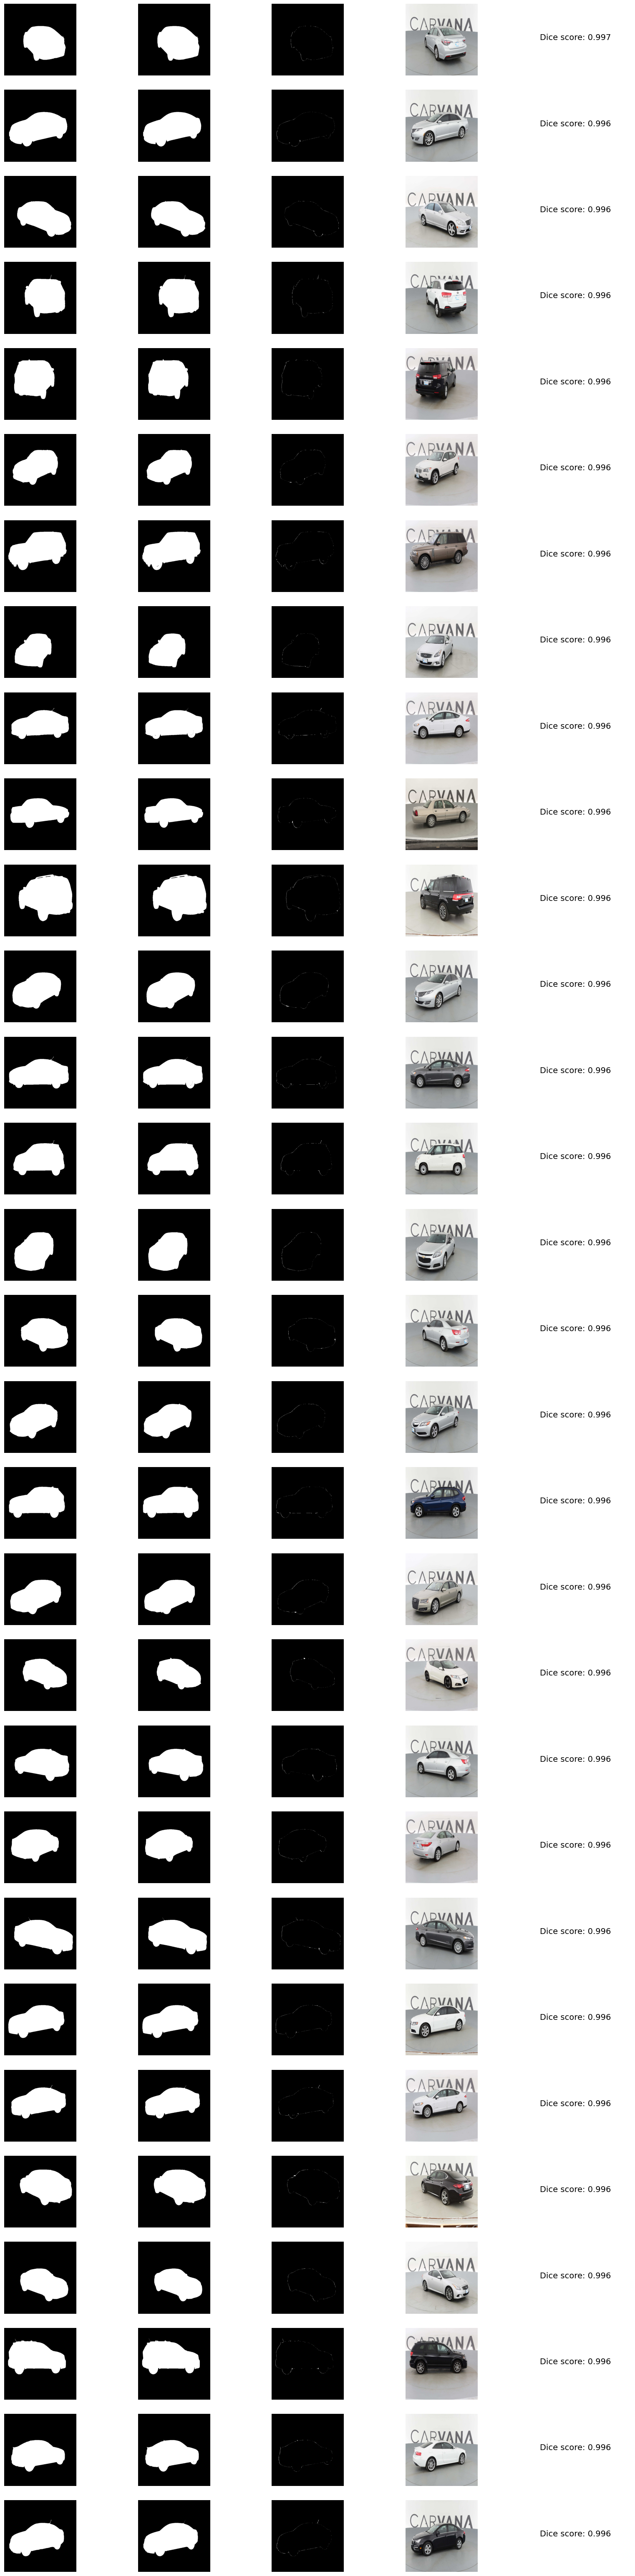

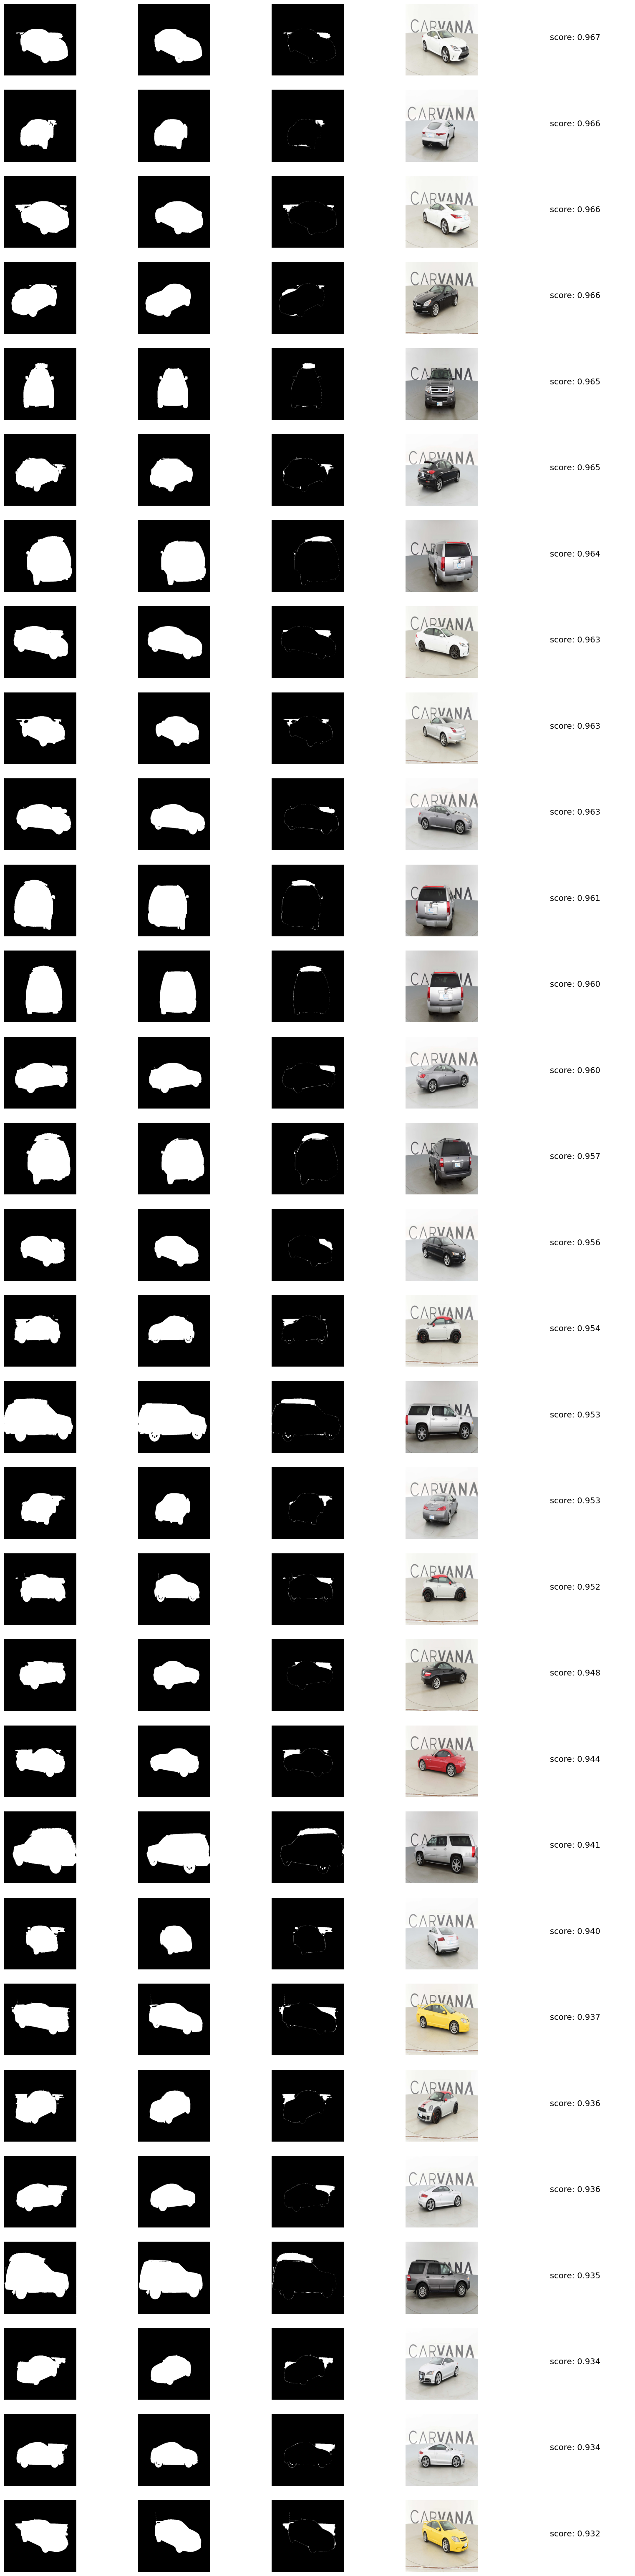

In [71]:
def visualize_images(image_list, N):
    # 上位N個と下位N個の画像を取得する
    top_list = image_list[:N]
    bottom_list = image_list[-N:]

    # 画像を表示する
    fig, axs = plt.subplots(N, 5, figsize=(20, 80))
    for i in range(N):
        # 上位N個の画像を表示する
        top_image = top_list[i]["pred"].cpu().numpy()
        axs[i][0].imshow(top_image, cmap="gray")
        axs[i][0].axis('off')
        
        top_image = top_list[i]["label"].cpu().numpy()
        axs[i][1].imshow(top_image, cmap='gray')
        axs[i][1].axis('off')

        axs[i][2].imshow(np.abs(top_list[i]["pred"] - top_list[i]["label"]).cpu().numpy(), cmap='gray')
        axs[i][2].axis('off')

        axs[i][4].text(0.5, 0.5, f"Dice score: {top_list[i]['dice_score']:.3f}", fontsize=14, ha='center')
        axs[i][4].axis('off')

        top_image = top_list[i]["orig"].cpu().numpy().transpose((1,2,0))
        axs[i][3].imshow(top_image)
        axs[i][3].axis('off')

    fig, axs = plt.subplots(N, 5, figsize=(20, 80))
    for i in range(N):
        # 下位N個の画像を表示する
        bottom_image = bottom_list[i]["pred"].cpu().numpy()
        axs[i][0].imshow(bottom_image, cmap='gray')
        axs[i][0].axis('off')
        
        bottom_image = bottom_list[i]["label"].cpu().numpy()
        axs[i][1].imshow(bottom_image, cmap='gray')
        axs[i][1].axis('off')

        axs[i][2].imshow(np.abs(bottom_list[i]["pred"] - bottom_list[i]["label"]).cpu().numpy(), cmap='gray')
        axs[i][2].axis('off')

        axs[i][4].text(0.5, 0.5, f"score: {bottom_list[i]['dice_score']:.3f}", fontsize=14, ha='center')
        axs[i][4].axis('off')

        bottom_image = bottom_list[i]["orig"].cpu().numpy().transpose((1,2,0))
        axs[i][3].imshow(bottom_image)
        axs[i][3].axis('off')

    plt.show()
# 可視化する
N=30
visualize_images(sorted_visual_list, N)

In [72]:
from collections import OrderedDict

# https://qiita.com/conta_/items/c3e173e891145e87e668
def fix_model_state_dict(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k
        if name.startswith('module.'):
            name = name[7:]  # remove 'module.' of dataparallel
        new_state_dict[name] = v
    return new_state_dict

## ランレングス符号化

In [78]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [79]:
train_img_pathes = sorted(list(map(lambda x: os.path.join(TRAIN_IMG_DIR, x), os.listdir(TRAIN_IMG_DIR))))
img = np.array(Image.open(train_img_pathes[0]))
original_shape = img.shape[:2] # Height, Width

In [80]:
if 'model' not in locals():
    ckpt = torch.load(MODEL_PATH, map_location=DEVICE)
    if type(ckpt) is torch.nn.DataParallel:
        ckpt = fix_model_state_dict(ckpt.state_dict())
    
    model = UNet()
    model.load_state_dict(ckpt)
    if DEVICE == 'cuda' and torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)
        torch.backends.cudnn.benchmark = True
    model.to(DEVICE)

model.eval()
with torch.no_grad():
    data = valid_data.__getitem__(0)
    name, img, mask = data['name'], data['image'], data['mask'] 
    print(f'name: {name}')
    print(f'image_shape: {img.shape}')
    print(f'mask_shape: {mask.shape}')
    
    img = img.unsqueeze(0).to(DEVICE)
    output = model(img)
    # output = output.squeeze()
    pred = post_proc(output,"otsu",original_shape[:2])
    print(f'pred_shape: {pred.shape}')

name: b63a6f7952d4_09.jpg
image_shape: torch.Size([3, 572, 572])
mask_shape: torch.Size([572, 572])
pred_shape: torch.Size([1280, 1918])


/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


pred (min,max): (0.0:1.0)
pred shape: torch.Size([1280, 1918])
score: 0.9899416565895081
enc_mask: 695276 17 695311 18 697158 99 699066 121 700951 159 702860 196 704773 214 706669


/tmp/ipykernel_40313/318939094.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1=img1.astype(np.bool)
/tmp/ipykernel_40313/318939094.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im2=img2.astype(np.bool)


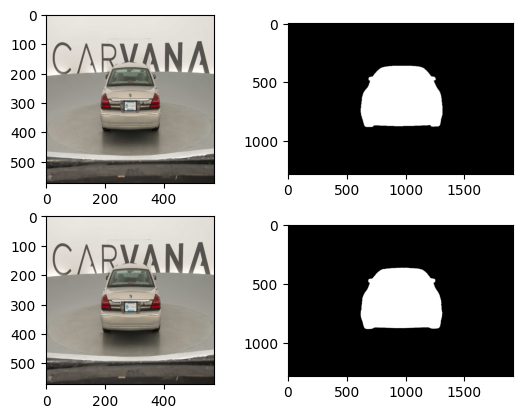

In [86]:
# check validation encoding
# valid_data = CarvanaDataset(val_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR, validation,True)
data = valid_data.__getitem__(0)
ref_name = data['name']
ref_img = data['image'].squeeze().detach().cpu().numpy().transpose(1,2,0)
ref_mask = data['mask']
ref_mask = ref_mask.reshape(1,1, ref_mask.size(0), ref_mask.size(1))
ref_mask = F.interpolate(ref_mask, tuple(original_shape[:2]), mode='bilinear')
ref_mask = ref_mask.squeeze().detach().cpu().numpy()

print(f'pred (min,max): ({torch.min(pred)}:{torch.max(pred)})')
print(f'pred shape: {pred.size()}')
# print('ref_mask: ', ref_mask.))

# pred_img = img.squeeze().detach().cpu().numpy().transpose(1,2,0)
pred_img = ref_img
pred_mask = pred.detach().cpu().numpy()
score = dice(ref_mask, pred_mask)
print(f'score: {score}')
encoded_mask = rle_encode(pred_mask)
print(f'enc_mask: {encoded_mask[:80]}')

fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0, 0].imshow(ref_img, cmap="gray", label='train_image')
ax[0, 1].imshow(ref_mask, cmap="gray", label='train_mask')
ax[1, 0].imshow(pred_img, cmap="gray", label='pred_image')
ax[1, 1].imshow(pred_mask, cmap="gray", label='pred_mask')
plt.show()

In [82]:
df = pd.read_csv(os.path.join(DATAPATH, 'train_masks.csv'))
df[df.img == data['name']]

img                                           rle_mask
3560  b63a6f7952d4_09.jpg  693310 112 695201 171 697103 204 699009 228 70...

# 評価コード

In [96]:
def test(model, dataloader, data, save_preds=False):
    print("\n--------Predict Testset---------\n")
    model.eval()
    counter = 0
    # number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    
    masks, names, scores = [], [], []
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader),total=num_batches):
            counter+=1
            # name, image, mask = data['name'], data["image"], data['mask']
            name, image = data['name'], data["image"].to(DEVICE)
           # image,mask = data["image"].to(DEVICE),data["mask"].to(DEVICE)
            # print('image.shape:', image.shape)
            
            # print('mask.shape:', mask.shape)

            # image = image.unsqueeze(0).to(DEVICE)
            outputs = model(image)
            # print('outputs.shape:', outputs.shape)

            preds = post_proc(outputs,"otsu", original_shape[:2])
            # preds = post_proc(outputs)
            preds = preds.squeeze().detach().cpu().numpy()
            # mask = mask.detach().cpu().numpy()
            # print('preds.shape: ', preds.shape)
            
            if save_preds:
                save_dir = os.path.join(os.path.join(BASE_DIR, 'preds'))
                save_path = list(map(lambda x: os.path.join(save_dir, x + '.npy'), name))
                for x in zip(save_path, preds):
                    np.save(x[0], x[1])
                
            # score = list(map(lambda x: dice(x[0], x[1]), zip(preds, mask)))
            encoded_mask = list(map(rle_encode, preds))
            # plt.imshow(masks[0],cmap="gray")
            # print('score: ', score)
            
            names.append(name)
            masks.append(encoded_mask)
            # scores.append(score)

    # return masks, names, scores
    return masks, names

In [97]:
if next(model.parameters()).is_cuda:
    print('Model is on CUDA device')
else:
    print('Model is on CPU')

Model is on CUDA device


In [98]:
if RUN_TEST:
    test_images_path = os.listdir(TEST_IMG_DIR)
    test_data = CarvanaDataset(test_images_path, TEST_IMG_DIR, None, validation_transform, False)
    test_dataloader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False)

    # score, preds = evaluate(model, test_dataloader, test_data)
    masks, names = test(model, test_dataloader, test_data, save_preds=False)

    # for Testing on Single datapoint after training
    # plt.imshow(np.transpose(np.array(data['image']),(1,2,0)),cmap="gray")


--------Predict Testset---------



  0%|          | 0/6254 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
 44%|████▎     | 2733/6254 [1:38:51<2:07:22,  2.17s/it]


KeyboardInterrupt: 

# 推論結果のSubmit

In [ ]:
import itertools
def create_submission(masks, names):
    print('Create submission...')
    m = itertools.chain.from_iterable(masks)
    n = itertools.chain.from_iterable(names)
    
    # df = pd.read_csv(os.path.join(DATAPATH, 'sample_submission.csv'))
    df = pd.DataFrame(data={'img': n, 'rle_mask': m}).sort_values('img')
    # df.append({'img':results[0], 'rle_mask':results[1]}, ignore_index=True)
    df.drop_duplicates(subset='img', keep='last', ignore_index=True, inplace=True)
    submit_csv_path=os.path.join(os.path.dirname(SAVE_PATH),"submission.gz")
    df.to_csv(submit_csv_path, index=False, compression='gzip')
    
    return df

In [ ]:
create_submission(masks, names)